In [1]:
import numpy as np
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
import os
import glob
import torchvision.models as models
import copy
import time

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


# Load data

## Taco Class

In [104]:
class Taco(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=os.path.join(os.getcwd(), 'Project1.2', 'data', 'splitted')):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

## Load and plot some images

In [19]:
batch_size = 64

trans = transforms.Compose([ 
                            transforms.ToTensor(),
                            transforms.Resize((256, 256)),
                            ])

trainset = Taco(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Taco(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

Image shape: (256, 256)


<Figure size 1440x720 with 0 Axes>

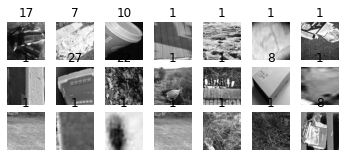

In [20]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

print(f"Image shape: {images[0].numpy()[0].shape}")

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

# Train function

In [3]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, criterion, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

# Visualize the model predictions function

In [4]:
def visualize_model(model, num_images=15):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            fig, axs = plt.subplots(3,5, figsize=(20,10))
            c = 0
            # plot 15 images in a grid 3x5
            for j in range(3):
                for k in range(5):
                    c += 1
                    pred = preds[c]
                    label = labels[c]
                    
                    axs[j,k].axis('off')
                    if pred == 0:
                        axs[j,k].set_title(f'Predicted: \nClass: {label}')
                    else:
                        axs[j,k].set_title(f'Predicted: \nClass: {label}')

                    # RGB
                    # img = inputs.cpu().data[c]
                    # img = np.asarray(img).transpose(1,2,0)
                    # axs[j,k].imshow(img)
                    # GRAY
                    img = inputs.cpu().data[c].numpy()[0]
                    axs[j,k].imshow(img, "gray")

                    if c == num_images:
                        model.train(mode=was_training)
                        plt.show()
                        return
            
        model.train(mode=was_training)

# Backbone model

In [5]:
resnet_152 = models.resnet152(pretrained=True)
num_ftrs = resnet_152.fc.in_features
out_features = resnet_152.fc.out_features
print("# of input features:", num_ftrs)
print("# of output features:", out_features)

# of input features: 2048
# of output features: 1000


In [6]:
resnet_152.fc

Linear(in_features=2048, out_features=1000, bias=True)

# Model #0 - Custom Model - only classification of object proposals

## Build model

In [76]:
class custom_model(nn.Module):
    def __init__(self, my_pretrained_model, num_categories=29, in_features=2048):
        super(custom_model, self).__init__()
        # pretrained model
        self.pretrained = my_pretrained_model

        # classifier
        self.fc = nn.Linear(in_features, num_categories, bias=True) # x, y, w, h

    def forward(self, x):
        x = self.pretrained(x)
        x = self.fc(x)
        
        return x

## Train function

In [88]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, criterion, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = criterion(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            test_loss.append(criterion(output, target).cpu().item())
            predicted = output.argmax(1)
            test_correct += (target==predicted).sum().cpu().item()
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

## Load model - not working

In [78]:
# pretrained model
resnet_152 = models.resnet152(pretrained=True)
# fetch all the layers of the resnet_152 network
layers = list(resnet_152.children())

# first layer is the resnet_152 model without the FC layer in the end
resnet_152 = nn.Sequential(*layers[:-1])

In [79]:
# initialize our model
model = custom_model(my_pretrained_model = resnet_152)
model

custom_model(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Con

In [53]:
# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in model.pretrained.parameters():
    param.requires_grad = False

# transfer model to gpu
model = model.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet_152.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Load model

In [95]:
# load pretrained model
resnet_152 = models.resnet152(pretrained=True)
num_ftrs = resnet_152.fc.in_features

# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in resnet_152.parameters():
    param.requires_grad = False

# adjust fully connected layer to have just 2 features output (binary classification)
resnet_152.fc = nn.Linear(num_ftrs, 29)

# transfer model to gpu
resnet_152 = resnet_152.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet_152.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(resnet_152.fc.parameters(), lr=0.001)

## Load data

In [96]:
batch_size = 64

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
trans = transforms.Compose([transforms.Resize(256), 
                            transforms.CenterCrop(224), 
                            transforms.ToTensor(),
                            normalize
                            ])

In [105]:
trainset = Taco(train=True, transform=trans)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = Taco(train=False, transform=trans)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [103]:
trainset.name_to_label

{'Aluminium foil': 0,
 'Background': 1,
 'Battery': 2,
 'Blister pack': 3,
 'Bottle': 4,
 'Bottle cap': 5,
 'Broken glass': 6,
 'Can': 7,
 'Carton': 8,
 'Cigarette': 9,
 'Cup': 10,
 'Food waste': 11,
 'Glass jar': 12,
 'Lid': 13,
 'Other plastic': 14,
 'Paper': 15,
 'Paper bag': 16,
 'Plastic bag & wrapper': 17,
 'Plastic container': 18,
 'Plastic glooves': 19,
 'Plastic utensils': 20,
 'Pop tab': 21,
 'Rope & strings': 22,
 'Scrap metal': 23,
 'Shoe': 24,
 'Squeezable tube': 25,
 'Straw': 26,
 'Styrofoam piece': 27,
 'Unlabeled litter': 28}

Image shape: (224, 224)


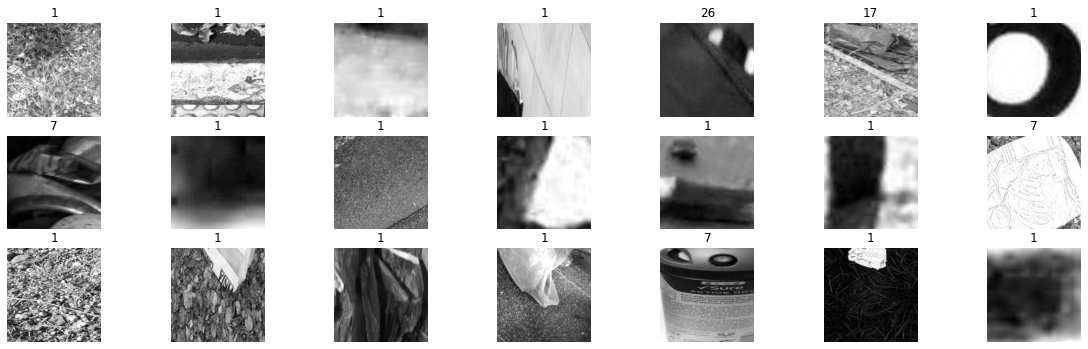

In [98]:
# plot a couple of images
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

print(f"Image shape: {images[0].numpy()[0].shape}")

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(images[i].numpy()[0], 'gray')
    plt.title(labels[i].item())
    plt.axis('off')

## Train model

In [99]:
# train model
results0 = train(resnet_152, optimizer_ft, criterion, num_epochs=10)

  0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 0/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.636	 test: 1.042	 Accuracy train: 81.0%	 test: 71.8%
Epoch 1/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.457	 test: 1.104	 Accuracy train: 85.6%	 test: 69.5%
Epoch 2/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.405	 test: 1.081	 Accuracy train: 87.0%	 test: 72.9%
Epoch 3/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.379	 test: 1.047	 Accuracy train: 87.8%	 test: 74.4%
Epoch 4/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.357	 test: 1.107	 Accuracy train: 88.7%	 test: 73.2%
Epoch 5/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.341	 test: 1.146	 Accuracy train: 89.1%	 test: 73.9%
Epoch 6/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.324	 test: 1.173	 Accuracy train: 89.5%	 test: 71.6%
Epoch 7/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.316	 test: 1.100	 Accuracy train: 89.8%	 test: 74.1%
Epoch 8/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.300	 test: 1.132	 Accuracy train: 90.4%	 test: 73.1%
Epoch 9/9
----------


  0%|          | 0/1035 [00:00<?, ?it/s]

Loss train: 0.294	 test: 1.166	 Accuracy train: 90.4%	 test: 73.7%


## Print results

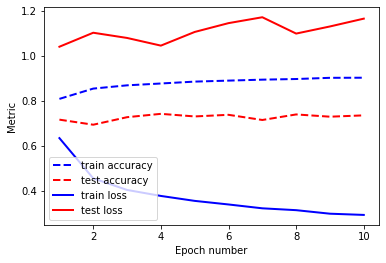

In [108]:
plt.plot(range(1,11), results0['train_acc'], color='blue', linestyle='dashed', linewidth=2, label="train accuracy")
plt.plot(range(1,11), results0['test_acc'], color='red', linestyle='dashed', linewidth=2, label="test accuracy")
plt.plot(range(1,11), results0['train_loss'], color='blue', linewidth=2, label="train loss")
plt.plot(range(1,11), results0['test_loss'], color='red', linewidth=2, label="test loss")
plt.legend()
plt.xlabel('Epoch number')
plt.ylabel('Metric')
plt.show()

## Plot results

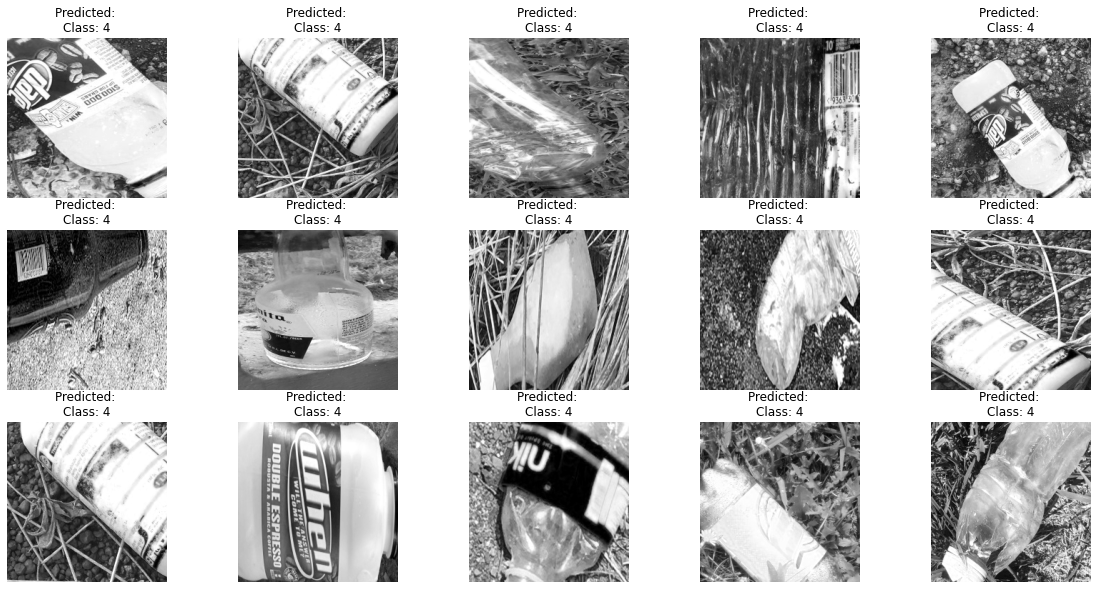

In [100]:
visualize_model(resnet_152)

# Model # 1 - Transfer Learning based NN (R-CNN)

## Build model

In [7]:
class BB_model(nn.Module):
    def __init__(self, my_pretrained_model, num_categories=28):
        super(BB_model, self).__init__()
        # load model and observe its fully-connected (output) layer
        pretrained = my_pretrained_model(pretrained=True)
        in_features = pretrained.fc.in_features
        # fetch all the layers of the resnet_152 network
        layers = list(pretrained.children())

        # first layer is the resnet_152 model without the FC layer in the end
        self.pretrained = nn.Sequential(*layers[:-1])

        # classifier and bounding box regressor FC layers
        # self.classifier = nn.Linear(in_features, num_categories+1) # we do not need this, as the SVM will do this job
        self.bb = nn.Linear(in_features, 4) # x, y, w, h

    def forward(self, x):
        x = self.pretrained(x)
        feature_output = x
        bb_output = self.bb(x)
        
        return feature_output, bb_output


## SVM to classify region features

In [10]:
from sklearn import svm

In [11]:
clf = svm.SVC()

## Train model

In [12]:
# pretrained model
pretrained = models.resnet152(pretrained=True)
# initialize our model
model = BB_model(pretrained)

# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in model.resnet_152.parameters():
    param.requires_grad = False

# transfer model to gpu
model = model.to(device)

# add loss function
criterion = nn.CrossEntropyLoss()

# Observe that all only the final layer parameters are being optimized
# optimizer_ft = torch.optim.SGD(resnet_152.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(resnet_152.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

AttributeError: cannot assign module before Module.__init__() call

## Train model

In [45]:
# train model
batch_size = 64
transfer_learning_results = train(resnet_152, optimizer_ft, criterion, num_epochs=7)

  0%|          | 0/7 [00:00<?, ?epoch/s]

Epoch 0/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.076	 test: 0.133	 Accuracy train: 97.3%	 test: 94.6%
Epoch 1/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.058	 test: 0.140	 Accuracy train: 98.0%	 test: 94.3%
Epoch 2/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.061	 test: 0.146	 Accuracy train: 98.0%	 test: 94.4%
Epoch 3/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.061	 test: 0.132	 Accuracy train: 97.6%	 test: 94.3%
Epoch 4/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.049	 test: 0.132	 Accuracy train: 98.5%	 test: 94.4%
Epoch 5/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.056	 test: 0.133	 Accuracy train: 98.1%	 test: 94.0%
Epoch 6/6
----------


  0%|          | 0/32 [00:00<?, ?it/s]

Loss train: 0.062	 test: 0.138	 Accuracy train: 97.8%	 test: 94.6%


## Visualize predictions

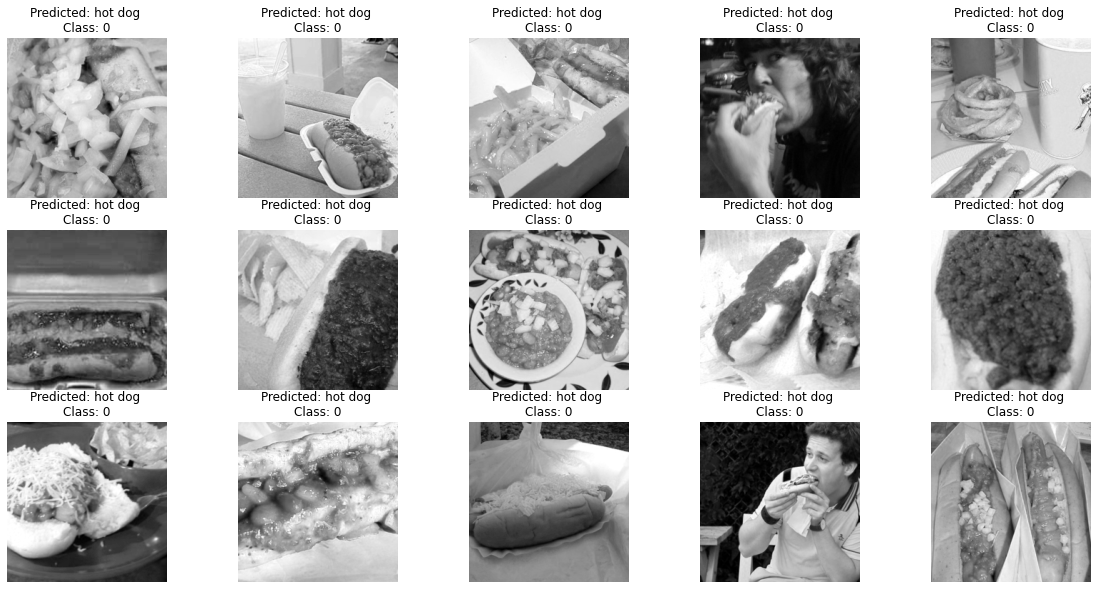

In [123]:
visualize_model(resnet_152)

# Model #2 - Bounding Box regression model

## Build model (Fast RCNN)

In [ ]:
class BB_model(nn.Module):
    def __init__(self, num_categories=28):
        # load model and observe its fully-connected (output) layer
        resnet_152 = models.resnet152(pretrained=True)
        in_features = resnet_152.fc.in_features
        # fetch all the layers of the resnet_152 network
        layers = list(resnet_152.children())

        # first layer is the resnet_152 model without the FC layer in the end
        self.resnet_152 = nn.Sequential(*layers[:-1])

        # classifier and bounding box regressor FC layers
        self.classifier = nn.Linear(in_features, num_categories+1)
        self.bb = nn.Linear(in_features, 4) # x, y, w, h

    def forward(self, x):
        x = self.resnet_152(x)
        classifier_output = self.classifier(x)
        bb_output = self.bb(x)
        
        return classifier_output, bb_output


## Training function

In [ ]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
  
    for epoch in tqdm(range(num_epochs), unit='epoch'):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, y_class, y_bb) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, y_class, y_bb = data.to(device), y_class.to(device), y_bb.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            out_class, out_bb = model(data)
            #Compute the loss
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb
            # set gradients to 0 after each mini-batch to not accumulate gradients on subsequent backpropagations
            optimizer.zero_grad()
            # Backward pass through the network
            loss.backward()
            # Update the weights
            optimizer.step()
            
            # keep the training loss
            train_loss.append(loss.item())
            # find predicted class and compute how many were correctly classified
            predicted = out_class.argmax(1)
            train_correct += (y_class==predicted).sum().cpu().item()

        #Compute the test accuracy
        test_loss = []
        test_correct = 0
        model.eval()
        for data, y_class, y_bb in test_loader:
            data, y_class, y_bb = data.to(device), y_class.to(device), y_bb.to(device)
            with torch.no_grad():
                out_class, out_bb = model(data)

            # find predicted class and compute how many were correctly classified
            predicted = out_class.argmax(1)
            test_correct += (y_class==predicted).sum().cpu().item()

            # keep test losses
            class_test_loss = F.cross_entropy(out_class, y_class, reduction="sum")
            bb_test_loss = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss = class_test_loss + bb_test_loss
            
        out_dict['train_acc'].append(train_correct/len(trainset))
        out_dict['test_acc'].append(test_correct/len(testset))
        out_dict['train_loss'].append(np.mean(train_loss))
        out_dict['test_loss'].append(np.mean(test_loss))
        print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
              f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%")

    return out_dict

## Train model

In [ ]:
# transfer model to gpu
model = BB_model.to(device)

# freeze all the layers except from the last one
# Parameters of newly constructed modules have requires_grad=True by default
for param in model.parameters():
    param.requires_grad = False
model.classifier.requires_grad = True
model.bb.requires_grad = True

# Observe that all only the final layer parameters are being optimized
optimizer_ft = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# train model
results = train(resnet_152, optimizer_ft, criterion, num_epochs=7)

# ROI pooling layer network
Using a ROI pooling layer after extracting the feature map with a CNN, we no longer need to crop and resize the object proposals!

In [29]:
from torchvision.ops import roi_pool

## Function to exract bounding boxes

This will be run after the CNN that produces the feature map

In [ ]:
def get_rois(features, bboxes, out_size, scale):
    
    out_rois = roi_pool(input=features, boxes=bboxes, output_size=out_size, spatial_scale=scale)
    return out_rois

In [ ]:
# example of usage
# def forward(self, features, rois):
#     if self.use_torchvision:
#         from torchvision.ops import roi_pool as tv_roi_pool
#         return tv_roi_pool(features, rois, self.out_size,
#                             self.spatial_scale)
#     else:
#         return roi_pool(features, rois, self.out_size, self.spatial_scale) 

# Model #3 - CNN for object proposals (faster RCNN)


In [6]:
resnet_152 = models.resnet152(pretrained=True)
resnet_152.forward

<bound method ResNet.forward of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

## Model

In [ ]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, num_categories):
        # load model and observe its fully-connected (output) layer
        resnet_152 = models.resnet152(pretrained=True)
        in_features = resnet_152.fc.in_features
        # fetch all the layers of the resnet_152 network
        layers = list(resnet_152.children())

        # first layer is the resnet_152 model without the FC layer and the avg_pool in the end
        self.layer1 = nn.Sequential(*layers[:-1])

        # now, as per the original paper, we will add a convolutional layer and split between the classification and bounding box output
        self.layer2 = nn.Conv2d(in_channels= 3, 
                                out_channels = 32, 
                                kernel_size = 3,
                                stride = 1, 
                                padding = 1)

        self.classification = nn.Conv2d(256, 4*(num_categories), 1), # x,y,w,h for every anchor corresponding to every category

        self.bb_regression = nn.Conv2d(256, 2*(num_categories), 1), # 0/1 classification for every category

    def forward(self, x):
        x = self.layer1(x)
        x_class = self.classification(x)
        x_bbox = self.bb_regression(x)
        
        return x_class, x_bbox


In [ ]:
class Detector(nn.Module):
    def __init__(self, num_categories=28):
        # load model and observe its fully-connected (output) layer
        resnet_152 = models.resnet152(pretrained=True)
        in_features = resnet_152.fc.in_features
        # fetch all the layers of the resnet_152 network
        layers = list(resnet_152.children())

        # first layer is the resnet_152 model without the FC layer in the end
        self.resnet_152 = nn.Sequential(*layers[:-1])

        # classifier and bounding box regressor FC layers
        self.classifier = nn.Linear(in_features, num_categories+1)
        self.bb = nn.Linear(in_features, 4) # x, y, w, h

    def forward(self, x):
        x = self.resnet_152(x)
        classifier_output = self.classifier(x)
        bb_output = self.bb(x)
        
        return classifier_output, bb_output

In [ ]:
class FullModel(nn.Module):
    def __init__(self, num_categories=28):
        # load model and observe its fully-connected (output) layer
        resnet_152 = models.resnet152(pretrained=True)
        in_features = resnet_152.fc.in_features
        # fetch all the layers of the resnet_152 network
        layers = list(resnet_152.children())

        # first layer is the resnet_152 model without the FC layer in the end
        self.resnet_152 = nn.Sequential(*layers[:-1])

        # classifier and bounding box regressor FC layers
        self.classifier = nn.Linear(in_features, num_categories+1)
        self.bb = nn.Linear(in_features, 4) # x, y, w, h

    def forward(self, x):
        x = self.resnet_152(x)
        classifier_output = self.classifier(x)
        bb_output = self.bb(x)
        
        return classifier_output, bb_output


# Finito